# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle, time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.manifold import spectral_embedding
from sklearn.neighbors import kneighbors_graph
from scipy import sparse

# Helpers

In [2]:
def unpickle(file):
  with open(file, 'rb') as fo:
      dict = pickle.load(fo, encoding='bytes')
  return dict

def get_and_scale_cifar10_data(sort_flag, train_samples_per_class=5000, test_samples=10000):
  for batch in range(1, 6):
    data_dict = unpickle(f"data_batch_{batch}")
    if batch == 1:
      X_train = data_dict[b'data']
      y_train = data_dict[b'labels']
    else:
      X_train = np.concatenate((X_train, data_dict[b'data']))
      y_train = np.concatenate((y_train, data_dict[b'labels']))

  data_dict = unpickle("test_batch")
  X_test = data_dict[b'data']
  y_test = np.array(data_dict[b'labels'])

  data_dict = unpickle("batches.meta")
  label_names = list(str(name)[2:-1] for name in data_dict[b'label_names'])
  
  scaler = MinMaxScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  if sort_flag == 1:
    sort_idx = np.argsort(y_train)
    X_train_scaled = X_train_scaled[sort_idx]
    y_train = y_train[sort_idx]
  
  classes = np.unique(y_train)
  n_classes = len(classes)
  for n_class in range(n_classes):
    class_idx = 5000*n_class + np.arange(0, train_samples_per_class)
    if n_class == 0:
      X_train_scaled_sampled = X_train_scaled[class_idx, :]
      y_train_sampled = y_train[class_idx]
    else:
      X_train_scaled_sampled = np.concatenate((X_train_scaled_sampled, X_train_scaled[class_idx, :])) 
      y_train_sampled = np.concatenate((y_train_sampled, y_train[class_idx]))
  
  X_test_scaled_sampled = X_test_scaled[:test_samples, :]
  y_test_sampled = y_test[:test_samples]

  print(X_train_scaled_sampled.shape, y_train_sampled.shape, X_test_scaled_sampled.shape, y_test_sampled.shape)

  return X_train_scaled_sampled, X_test_scaled_sampled, y_train_sampled, y_test_sampled, label_names


In [3]:
class MySpectralPlusKMeans():

  def __init__(self, 
               neighbors_mode='connectivity', 
               neighbors_include_self=True,
               spectral_norm_laplacian=False, 
               spectral_drop_first=False,
               random_state=0, 
               max_iter=1000):
    
    self.neighbors_mode = neighbors_mode
    self.neighbors_include_self = neighbors_include_self
    self.spectral_norm_laplacian = spectral_norm_laplacian
    self.spectral_drop_first = spectral_drop_first
    self.random_state = random_state
    self.max_iter = max_iter

  def fit_transform(self, X, n_neighbors=50, spectral_components=8):
    print("Spectral Clustering --> fit+trasform ...")
    self.n_neighbors = n_neighbors
    self.spectral_components = spectral_components
    tic = time.time()
    self.KN = kneighbors_graph(X, 
                               n_neighbors=self.n_neighbors, 
                               mode=self.neighbors_mode, 
                               include_self=self.neighbors_include_self)
    
    self.V = spectral_embedding(self.KN, 
                                n_components=self.spectral_components, 
                                norm_laplacian=self.spectral_norm_laplacian, 
                                drop_first=self.spectral_drop_first)
    self.dt_spectral= time.time() - tic
    return self.V, self.dt_spectral
  
  def plot_eigvals(self, train_or_test_str='Train'):
    similarity_matrix = (self.KN + self.KN.T)/2
    D = sparse.diags(np.array(sparse.csr_matrix.sum(similarity_matrix, axis=1)).flatten(), offsets=0)
    self.L = D - similarity_matrix

    eigvals = list()
    for n in range(self.spectral_components):
      v = self.V[:, n]
      lambda_v = sparse.csr_matrix.dot(self.L, v)
      eigval = np.divide(lambda_v, v)[0]
      eigvals.append(eigval)

    plt.figure(figsize=(30, 10))
    plt.plot(np.array(eigvals), "*")
    plt.title(f"Eigenvalues ({train_or_test_str} set)")
    plt.xlabel("Number of eigenvalue")
    plt.ylabel("Eigenvalue")
    plt.show()

  def fit_kmeans(self, X, n_clusters=10):
    self.n_clusters = n_clusters
    tic = time.time()
    self.k_means = KMeans(n_clusters=self.n_clusters, 
                          random_state=self.random_state, 
                          max_iter=self.max_iter)
    self.k_means.fit(X[:, 1:])
    self.dt_kmeans = time.time() - tic
    return self.dt_kmeans
  
  def predict(self, X):
    self.y_preds = self.k_means.predict(X[:, 1:])
    return self.y_preds

  def get_results(self, X, y):
    self.p_list = list()
    for true_class in range(self.n_clusters):
      y_preds_c = self.k_means.predict(X[:, 1:][y == true_class])
      s = pd.Series(y_preds_c).value_counts()
      p = float("{:.2f}".format(100 * s.max() / s.sum()))
      self.p_list.append(p)
      print(f"True Class: {true_class} --> {p}%")
    self.p_mean = np.array(self.p_list).mean()
    print("==============================")
    print(f"Mean percentage = {self.p_mean}%")
    print("==============================")

    return self.p_mean

# MAIN

In [4]:
# constants
train_samples_per_class = 5000
test_samples = 10000
tSNE_components = 2

# get and scale data
X_train, X_test, y_train, y_test, label_names = get_and_scale_cifar10_data(sort_flag=1, test_samples=test_samples,
                                                                           train_samples_per_class=train_samples_per_class)

(50000, 3072) (50000,) (10000, 3072) (10000,)


## t-SNE

In [5]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

# dimensionality reduction tSNE
tSNE = TSNE(n_components=tSNE_components)
X_tsne = tSNE.fit_transform(X)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


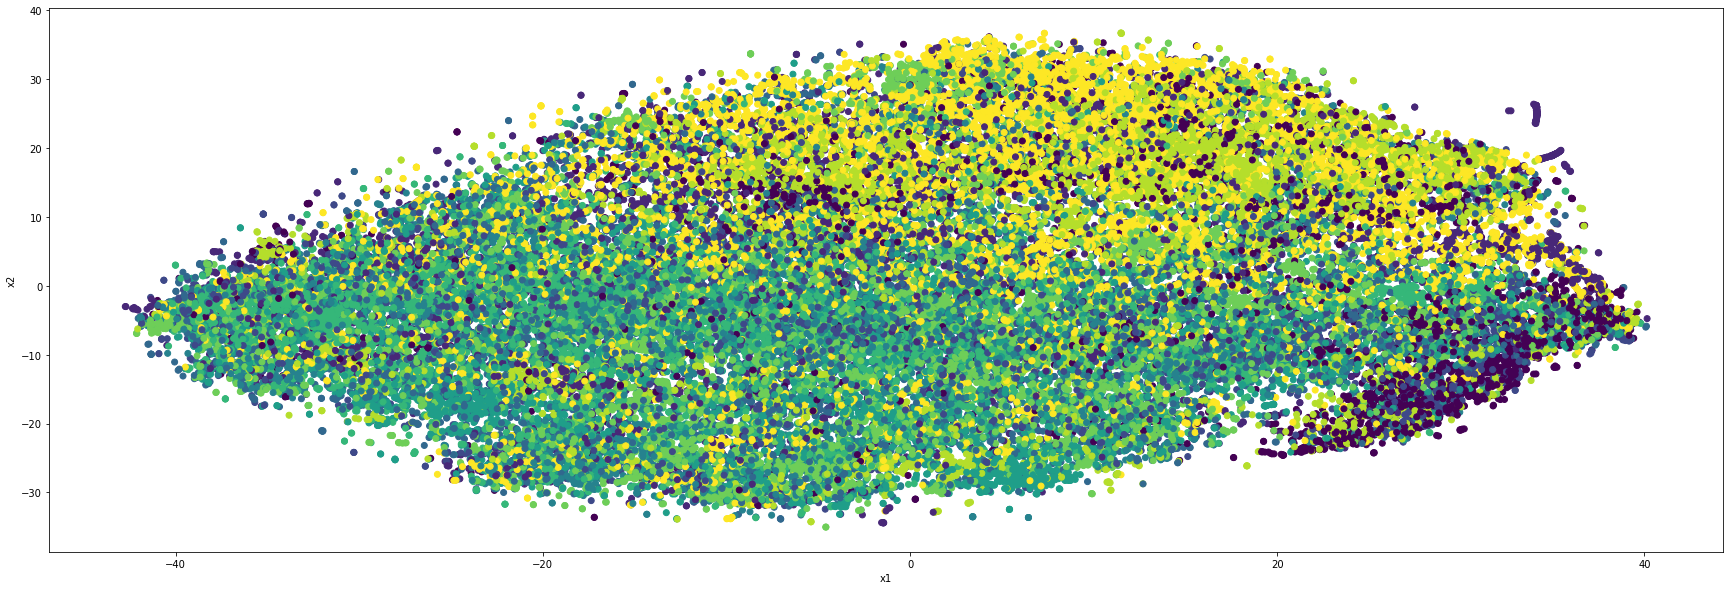

In [6]:
# plot tSNE
plt.figure(figsize=(30, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [7]:
X_train_tsne = X_tsne[:X_train.shape[0], :]
X_test_tsne = X_tsne[X_train.shape[0]:, :]
print(X_train_tsne.shape, X_test_tsne.shape)

(50000, 2) (10000, 2)


In [8]:
n_clusters = 10
k_means = KMeans(n_clusters=n_clusters, random_state=0, max_iter=1000)
k_means.fit(X_train_tsne)
y_preds = k_means.predict(X_test_tsne)

In [9]:
p_list = list()
for true_class in range(10):
  y_preds_c = k_means.predict(X_test_tsne[y_test == true_class])
  s = pd.Series(y_preds_c).value_counts()
  p = float("{:.2f}".format(100 * s.max() / s.sum()))
  p_list.append(p)
  print(f"True Class: {true_class} --> {p}%")
p_mean = np.array(p_list).mean()
print("==============================")
print(f"Mean percentage = {p_mean}%")
print("==============================")

True Class: 0 --> 38.7%
True Class: 1 --> 19.6%
True Class: 2 --> 19.6%
True Class: 3 --> 16.9%
True Class: 4 --> 22.2%
True Class: 5 --> 19.8%
True Class: 6 --> 24.2%
True Class: 7 --> 15.7%
True Class: 8 --> 26.2%
True Class: 9 --> 30.4%
Mean percentage = 23.330000000000002%


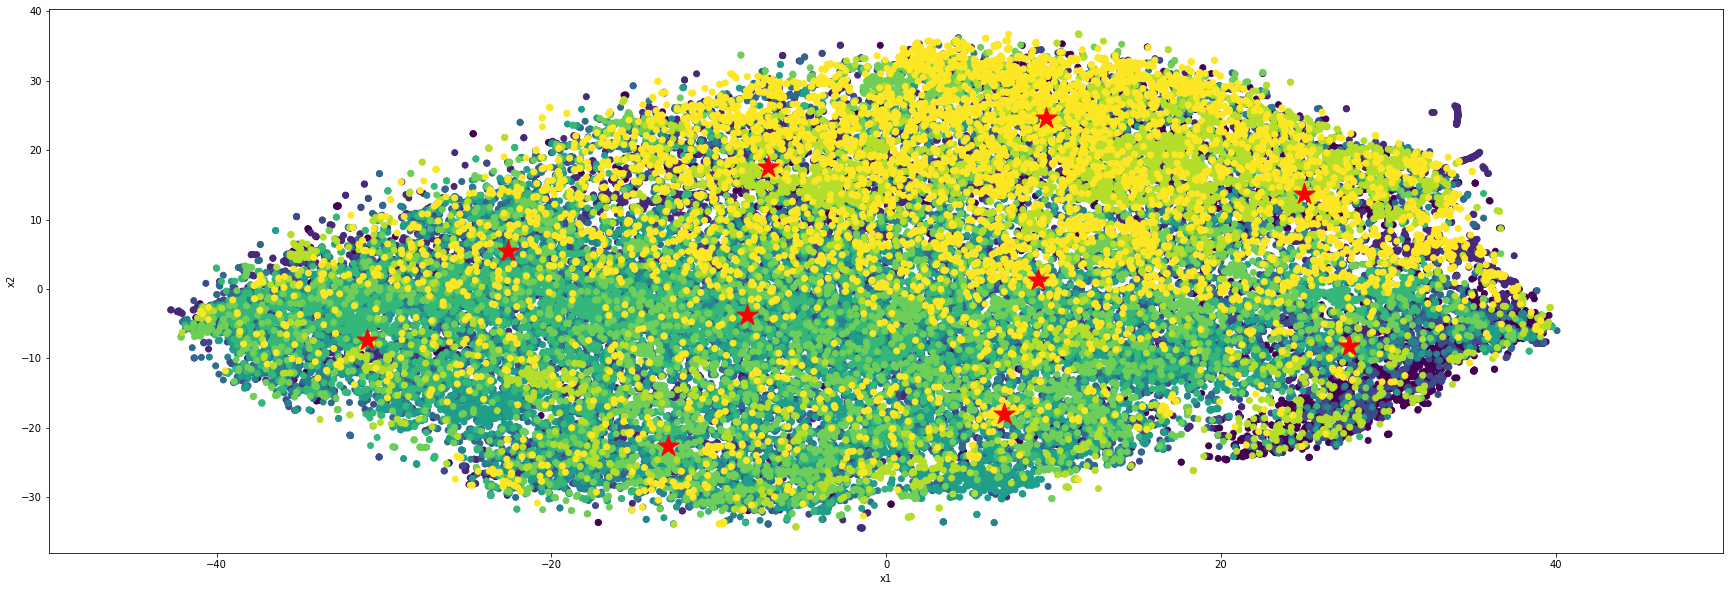

In [10]:
# plot tSNE (Train)
plt.figure(figsize=(30, 10))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train)
plt.scatter(k_means.cluster_centers_[:, 0], k_means.cluster_centers_[:, 1], c="r", marker="*", s=500)
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim([-50, 50])
plt.show()

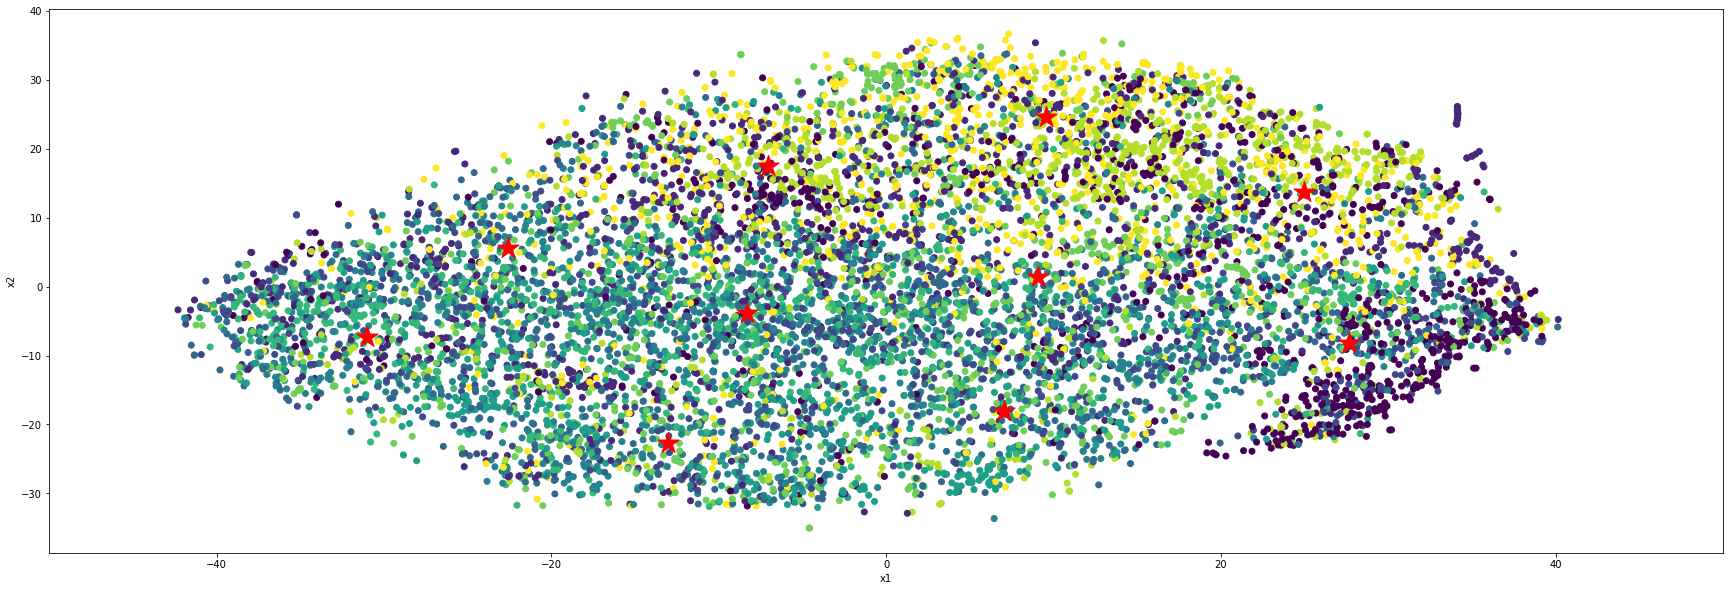

In [11]:
# plot tSNE (Test)
plt.figure(figsize=(30, 10))
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_test)
plt.scatter(k_means.cluster_centers_[:, 0], k_means.cluster_centers_[:, 1], c="r", marker="*", s=500)
plt.xlabel("x1")
plt.ylabel("x2")
plt.xlim([-50, 50])
plt.show()

## Spectral Clustering + K-Means

In [12]:
n_neighbors_list = [12, 25, 50, 100, 200, 300, 400, 500, 600, 700]
sc_start, sc_stop, sc_step = 3, 100, 1
spectral_components_list = np.arange(sc_start, sc_stop, sc_step)
n_clusters = 10
dt_spectral_train_lisτ = list()
dt_spectral_list, dt_kmeans_list, p_mean_list = list(), list(), list()
for n_neighbors in n_neighbors_list: 
  print(f"\n==================== n_neighbors={n_neighbors} ====================")
  sc_plus_kmeans = MySpectralPlusKMeans()
  V, dt_spectral = sc_plus_kmeans.fit_transform(X_tsne, 
                                                n_neighbors=n_neighbors, 
                                                spectral_components=sc_stop)
  dt_spectral_list.append(dt_spectral)
  for spectral_components in spectral_components_list:
    print(f"\n******* spectral_components={spectral_components} *******")
    V_kmeans_train = V[:X_train.shape[0], :spectral_components]
    V_kmeans_test = V[X_train.shape[0]:, :spectral_components]

    dt_kmeans = sc_plus_kmeans.fit_kmeans(V_kmeans_train, n_clusters=n_clusters)
    dt_kmeans_list.append(dt_kmeans)
    y_preds = sc_plus_kmeans.predict(V_kmeans_test)
    p_mean = sc_plus_kmeans.get_results(V_kmeans_test, y_test)
    p_mean_list.append(p_mean)


==================== n_neighbors=12 ====================
Spectral Clustering --> fit+trasform ...


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



******* spectral_components=3 *******
True Class: 0 --> 37.2%
True Class: 1 --> 16.8%
True Class: 2 --> 13.4%
True Class: 3 --> 13.5%
True Class: 4 --> 18.8%
True Class: 5 --> 15.5%
True Class: 6 --> 18.3%
True Class: 7 --> 15.2%
True Class: 8 --> 32.7%
True Class: 9 --> 23.9%
Mean percentage = 20.529999999999998%

******* spectral_components=4 *******
True Class: 0 --> 41.6%
True Class: 1 --> 17.3%
True Class: 2 --> 22.5%
True Class: 3 --> 20.3%
True Class: 4 --> 20.9%
True Class: 5 --> 20.8%
True Class: 6 --> 32.2%
True Class: 7 --> 15.4%
True Class: 8 --> 35.1%
True Class: 9 --> 33.6%
Mean percentage = 25.97%

******* spectral_components=5 *******
True Class: 0 --> 38.4%
True Class: 1 --> 20.8%
True Class: 2 --> 17.3%
True Class: 3 --> 17.1%
True Class: 4 --> 21.3%
True Class: 5 --> 23.3%
True Class: 6 --> 20.0%
True Class: 7 --> 18.3%
True Class: 8 --> 35.4%
True Class: 9 --> 39.5%
Mean percentage = 25.14%

******* spectral_components=6 *******
True Class: 0 --> 39.9%
True Class: 

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



******* spectral_components=3 *******
True Class: 0 --> 36.1%
True Class: 1 --> 15.8%
True Class: 2 --> 12.9%
True Class: 3 --> 14.8%
True Class: 4 --> 19.6%
True Class: 5 --> 15.4%
True Class: 6 --> 19.4%
True Class: 7 --> 15.2%
True Class: 8 --> 29.9%
True Class: 9 --> 23.7%
Mean percentage = 20.279999999999998%

******* spectral_components=4 *******
True Class: 0 --> 41.6%
True Class: 1 --> 17.6%
True Class: 2 --> 22.6%
True Class: 3 --> 20.9%
True Class: 4 --> 21.6%
True Class: 5 --> 21.2%
True Class: 6 --> 32.5%
True Class: 7 --> 15.6%
True Class: 8 --> 33.6%
True Class: 9 --> 33.1%
Mean percentage = 26.03%

******* spectral_components=5 *******
True Class: 0 --> 38.5%
True Class: 1 --> 21.3%
True Class: 2 --> 17.3%
True Class: 3 --> 17.8%
True Class: 4 --> 21.7%
True Class: 5 --> 24.0%
True Class: 6 --> 20.4%
True Class: 7 --> 18.1%
True Class: 8 --> 35.8%
True Class: 9 --> 39.0%
Mean percentage = 25.390000000000004%

******* spectral_components=6 *******
True Class: 0 --> 39.9%

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



******* spectral_components=3 *******
True Class: 0 --> 36.5%
True Class: 1 --> 15.8%
True Class: 2 --> 13.1%
True Class: 3 --> 14.4%
True Class: 4 --> 19.3%
True Class: 5 --> 15.5%
True Class: 6 --> 19.4%
True Class: 7 --> 15.3%
True Class: 8 --> 30.2%
True Class: 9 --> 23.5%
Mean percentage = 20.3%

******* spectral_components=4 *******
True Class: 0 --> 39.1%
True Class: 1 --> 16.4%
True Class: 2 --> 19.5%
True Class: 3 --> 21.1%
True Class: 4 --> 21.1%
True Class: 5 --> 20.3%
True Class: 6 --> 32.4%
True Class: 7 --> 15.6%
True Class: 8 --> 30.6%
True Class: 9 --> 31.3%
Mean percentage = 24.740000000000002%

******* spectral_components=5 *******
True Class: 0 --> 34.7%
True Class: 1 --> 18.9%
True Class: 2 --> 14.8%
True Class: 3 --> 18.9%
True Class: 4 --> 17.7%
True Class: 5 --> 24.4%
True Class: 6 --> 20.2%
True Class: 7 --> 17.9%
True Class: 8 --> 34.0%
True Class: 9 --> 38.2%
Mean percentage = 23.97%

******* spectral_components=6 *******
True Class: 0 --> 27.5%
True Class: 1

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)



******* spectral_components=3 *******
True Class: 0 --> 38.8%
True Class: 1 --> 16.3%
True Class: 2 --> 19.1%
True Class: 3 --> 21.0%
True Class: 4 --> 21.0%
True Class: 5 --> 20.0%
True Class: 6 --> 32.7%
True Class: 7 --> 15.6%
True Class: 8 --> 30.9%
True Class: 9 --> 31.6%
Mean percentage = 24.7%

******* spectral_components=4 *******
True Class: 0 --> 35.8%
True Class: 1 --> 19.5%
True Class: 2 --> 15.2%
True Class: 3 --> 17.7%
True Class: 4 --> 17.1%
True Class: 5 --> 24.1%
True Class: 6 --> 19.0%
True Class: 7 --> 18.0%
True Class: 8 --> 34.7%
True Class: 9 --> 38.8%
Mean percentage = 23.99%

******* spectral_components=5 *******
True Class: 0 --> 39.8%
True Class: 1 --> 26.0%
True Class: 2 --> 23.2%
True Class: 3 --> 15.3%
True Class: 4 --> 19.9%
True Class: 5 --> 19.1%
True Class: 6 --> 21.2%
True Class: 7 --> 17.9%
True Class: 8 --> 28.3%
True Class: 9 --> 31.6%
Mean percentage = 24.229999999999997%

******* spectral_components=6 *******
True Class: 0 --> 39.1%
True Class: 1

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)



******* spectral_components=3 *******
True Class: 0 --> 38.8%
True Class: 1 --> 16.1%
True Class: 2 --> 19.2%
True Class: 3 --> 21.1%
True Class: 4 --> 21.6%
True Class: 5 --> 20.2%
True Class: 6 --> 33.4%
True Class: 7 --> 15.5%
True Class: 8 --> 31.7%
True Class: 9 --> 31.4%
Mean percentage = 24.9%

******* spectral_components=4 *******
True Class: 0 --> 36.3%
True Class: 1 --> 19.3%
True Class: 2 --> 16.2%
True Class: 3 --> 17.9%
True Class: 4 --> 17.2%
True Class: 5 --> 24.1%
True Class: 6 --> 19.5%
True Class: 7 --> 17.8%
True Class: 8 --> 33.0%
True Class: 9 --> 37.8%
Mean percentage = 23.909999999999997%

******* spectral_components=5 *******
True Class: 0 --> 40.4%
True Class: 1 --> 25.5%
True Class: 2 --> 22.3%
True Class: 3 --> 15.1%
True Class: 4 --> 19.0%
True Class: 5 --> 19.5%
True Class: 6 --> 21.5%
True Class: 7 --> 17.0%
True Class: 8 --> 28.0%
True Class: 9 --> 31.0%
Mean percentage = 23.93%

******* spectral_components=6 *******
True Class: 0 --> 36.1%
True Class: 1

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)



******* spectral_components=3 *******
True Class: 0 --> 38.9%
True Class: 1 --> 16.2%
True Class: 2 --> 19.2%
True Class: 3 --> 21.2%
True Class: 4 --> 21.7%
True Class: 5 --> 20.4%
True Class: 6 --> 33.6%
True Class: 7 --> 15.4%
True Class: 8 --> 31.9%
True Class: 9 --> 31.4%
Mean percentage = 24.990000000000002%

******* spectral_components=4 *******
True Class: 0 --> 38.7%
True Class: 1 --> 18.8%
True Class: 2 --> 17.3%
True Class: 3 --> 17.3%
True Class: 4 --> 16.5%
True Class: 5 --> 23.3%
True Class: 6 --> 19.4%
True Class: 7 --> 17.9%
True Class: 8 --> 33.8%
True Class: 9 --> 38.5%
Mean percentage = 24.15%

******* spectral_components=5 *******
True Class: 0 --> 40.5%
True Class: 1 --> 25.1%
True Class: 2 --> 22.5%
True Class: 3 --> 14.8%
True Class: 4 --> 19.1%
True Class: 5 --> 19.2%
True Class: 6 --> 21.9%
True Class: 7 --> 16.3%
True Class: 8 --> 27.8%
True Class: 9 --> 30.9%
Mean percentage = 23.81%

******* spectral_components=6 *******
True Class: 0 --> 36.5%
True Class: 

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)



******* spectral_components=3 *******
True Class: 0 --> 38.8%
True Class: 1 --> 15.8%
True Class: 2 --> 18.9%
True Class: 3 --> 20.8%
True Class: 4 --> 21.7%
True Class: 5 --> 20.6%
True Class: 6 --> 34.1%
True Class: 7 --> 15.4%
True Class: 8 --> 31.4%
True Class: 9 --> 31.5%
Mean percentage = 24.9%

******* spectral_components=4 *******
True Class: 0 --> 38.9%
True Class: 1 --> 17.8%
True Class: 2 --> 17.6%
True Class: 3 --> 16.9%
True Class: 4 --> 15.8%
True Class: 5 --> 23.0%
True Class: 6 --> 19.4%
True Class: 7 --> 17.8%
True Class: 8 --> 32.7%
True Class: 9 --> 37.5%
Mean percentage = 23.74%

******* spectral_components=5 *******
True Class: 0 --> 40.6%
True Class: 1 --> 24.9%
True Class: 2 --> 22.1%
True Class: 3 --> 14.6%
True Class: 4 --> 18.8%
True Class: 5 --> 19.3%
True Class: 6 --> 21.7%
True Class: 7 --> 16.2%
True Class: 8 --> 27.8%
True Class: 9 --> 31.0%
Mean percentage = 23.7%

******* spectral_components=6 *******
True Class: 0 --> 36.4%
True Class: 1 --> 15.8%
Tru

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)



******* spectral_components=3 *******
True Class: 0 --> 38.9%
True Class: 1 --> 16.0%
True Class: 2 --> 19.3%
True Class: 3 --> 21.1%
True Class: 4 --> 21.7%
True Class: 5 --> 20.4%
True Class: 6 --> 33.4%
True Class: 7 --> 15.5%
True Class: 8 --> 32.0%
True Class: 9 --> 31.4%
Mean percentage = 24.970000000000002%

******* spectral_components=4 *******
True Class: 0 --> 38.9%
True Class: 1 --> 18.0%
True Class: 2 --> 17.7%
True Class: 3 --> 17.0%
True Class: 4 --> 16.5%
True Class: 5 --> 23.0%
True Class: 6 --> 19.3%
True Class: 7 --> 17.8%
True Class: 8 --> 32.7%
True Class: 9 --> 37.6%
Mean percentage = 23.849999999999998%

******* spectral_components=5 *******
True Class: 0 --> 38.2%
True Class: 1 --> 23.4%
True Class: 2 --> 17.8%
True Class: 3 --> 16.2%
True Class: 4 --> 18.0%
True Class: 5 --> 19.7%
True Class: 6 --> 22.7%
True Class: 7 --> 14.0%
True Class: 8 --> 27.8%
True Class: 9 --> 30.9%
Mean percentage = 22.87%

******* spectral_components=6 *******
True Class: 0 --> 36.0%

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)



******* spectral_components=3 *******
True Class: 0 --> 38.8%
True Class: 1 --> 15.9%
True Class: 2 --> 18.8%
True Class: 3 --> 21.0%
True Class: 4 --> 21.6%
True Class: 5 --> 20.1%
True Class: 6 --> 33.8%
True Class: 7 --> 15.6%
True Class: 8 --> 31.3%
True Class: 9 --> 31.7%
Mean percentage = 24.86%

******* spectral_components=4 *******
True Class: 0 --> 38.7%
True Class: 1 --> 18.6%
True Class: 2 --> 17.6%
True Class: 3 --> 17.4%
True Class: 4 --> 16.4%
True Class: 5 --> 23.2%
True Class: 6 --> 19.4%
True Class: 7 --> 17.8%
True Class: 8 --> 32.3%
True Class: 9 --> 37.3%
Mean percentage = 23.870000000000005%

******* spectral_components=5 *******
True Class: 0 --> 38.5%
True Class: 1 --> 26.9%
True Class: 2 --> 18.1%
True Class: 3 --> 16.3%
True Class: 4 --> 19.5%
True Class: 5 --> 22.5%
True Class: 6 --> 19.8%
True Class: 7 --> 15.2%
True Class: 8 --> 26.7%
True Class: 9 --> 30.8%
Mean percentage = 23.43%

******* spectral_components=6 *******
True Class: 0 --> 35.5%
True Class: 

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)



******* spectral_components=3 *******
True Class: 0 --> 38.8%
True Class: 1 --> 16.0%
True Class: 2 --> 18.9%
True Class: 3 --> 21.1%
True Class: 4 --> 21.8%
True Class: 5 --> 19.8%
True Class: 6 --> 33.4%
True Class: 7 --> 15.7%
True Class: 8 --> 31.3%
True Class: 9 --> 31.7%
Mean percentage = 24.85%

******* spectral_components=4 *******
True Class: 0 --> 38.9%
True Class: 1 --> 19.1%
True Class: 2 --> 17.7%
True Class: 3 --> 17.3%
True Class: 4 --> 16.0%
True Class: 5 --> 23.1%
True Class: 6 --> 19.5%
True Class: 7 --> 17.7%
True Class: 8 --> 31.7%
True Class: 9 --> 36.4%
Mean percentage = 23.740000000000002%

******* spectral_components=5 *******
True Class: 0 --> 40.8%
True Class: 1 --> 24.7%
True Class: 2 --> 22.2%
True Class: 3 --> 14.7%
True Class: 4 --> 19.1%
True Class: 5 --> 19.3%
True Class: 6 --> 22.0%
True Class: 7 --> 16.0%
True Class: 8 --> 27.5%
True Class: 9 --> 31.0%
Mean percentage = 23.73%

******* spectral_components=6 *******
True Class: 0 --> 35.6%
True Class: 

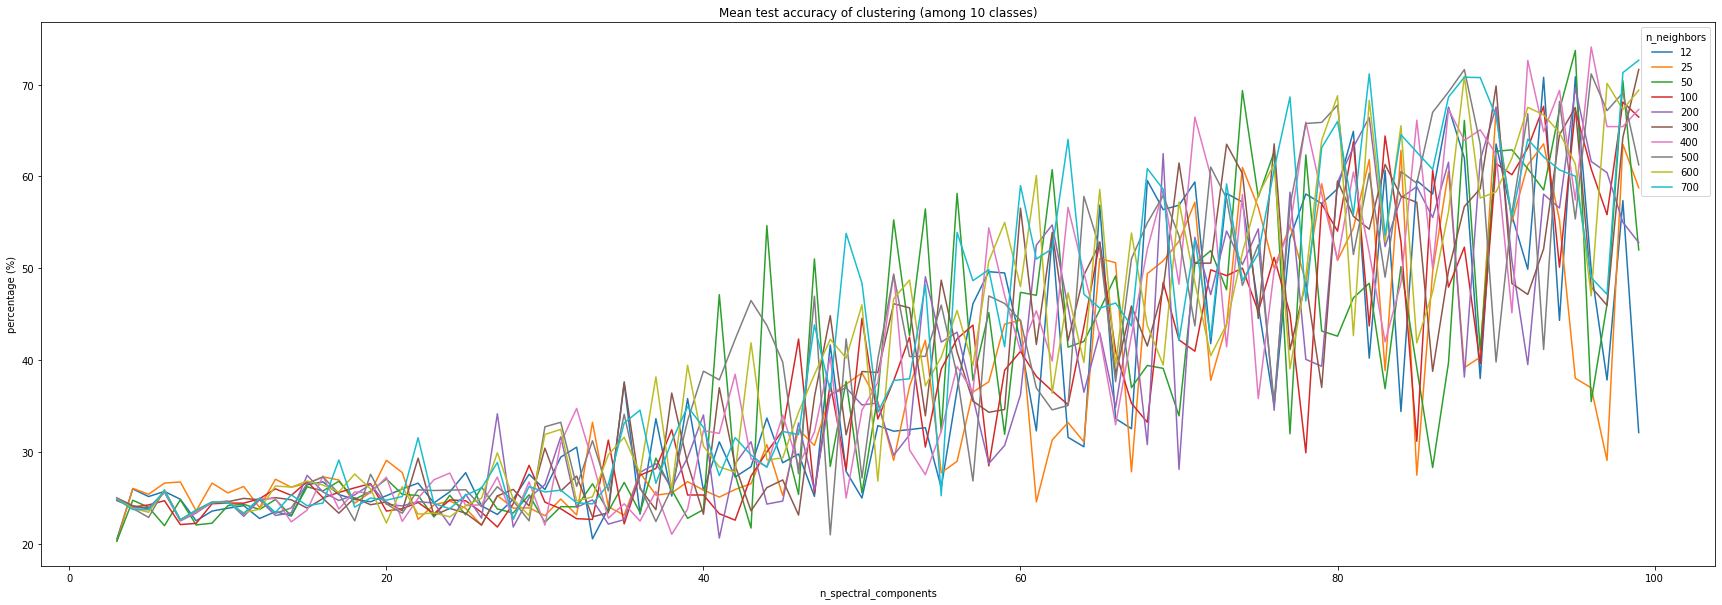

In [15]:
p_mean_arr = np.array(p_mean_list).reshape(len(n_neighbors_list), 
                                           spectral_components_list.shape[0])
plt.figure(figsize=(30, 10))
for i, n_neighbors in enumerate(n_neighbors_list):
  plt.plot(spectral_components_list, p_mean_arr[i, :], label=n_neighbors)
plt.xlabel("n_spectral_components")
plt.ylabel("percentage (%)")
plt.title("Mean test accuracy of clustering (among 10 classes)")
plt.legend(title="n_neighbors")
plt.show()

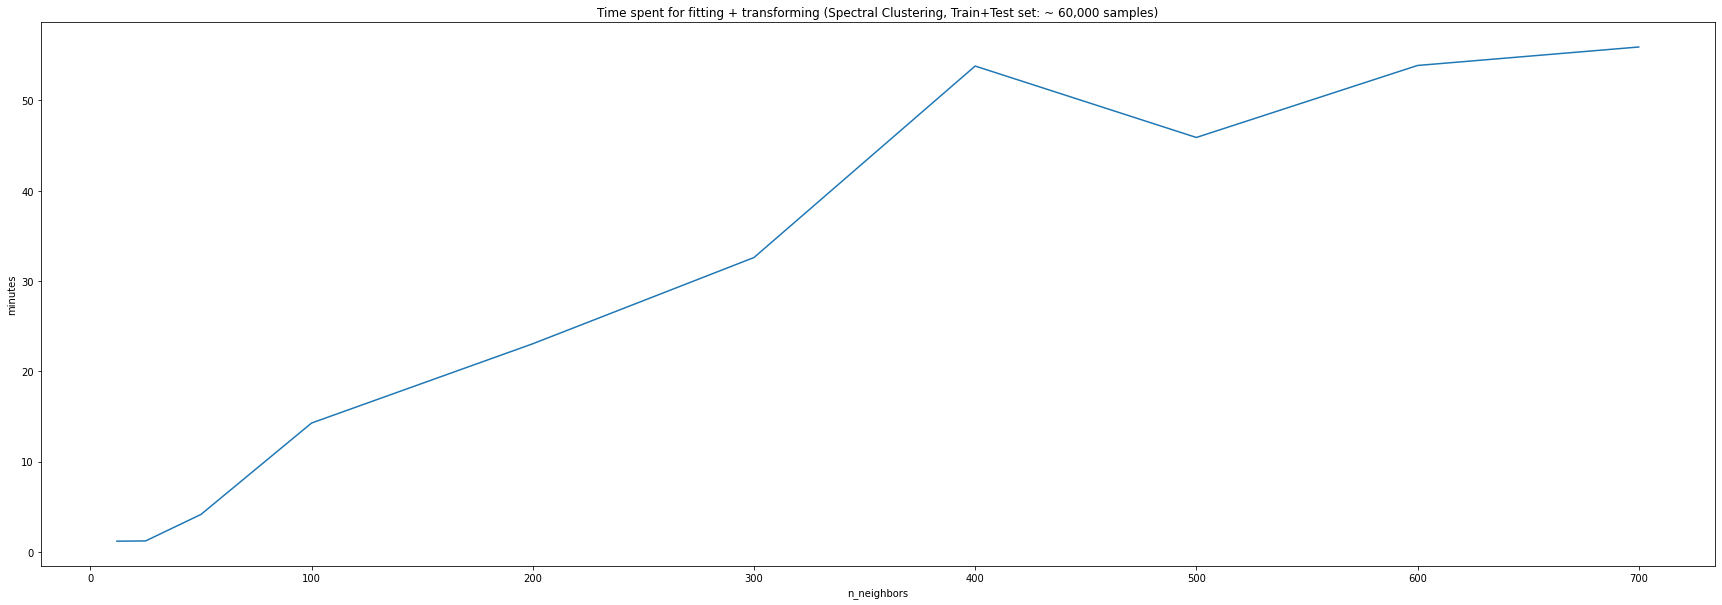

In [16]:
dt_spectral_arr = np.array(dt_spectral_list)
n_neighbors_arr = np.array(n_neighbors_list)
plt.figure(figsize=(30, 10))
plt.plot(n_neighbors_arr, dt_spectral_arr/60)
plt.xlabel("n_neighbors")
plt.ylabel("minutes")
plt.title("Time spent for fitting + transforming (Spectral Clustering, Train+Test set: ~ 60,000 samples)")
plt.show()

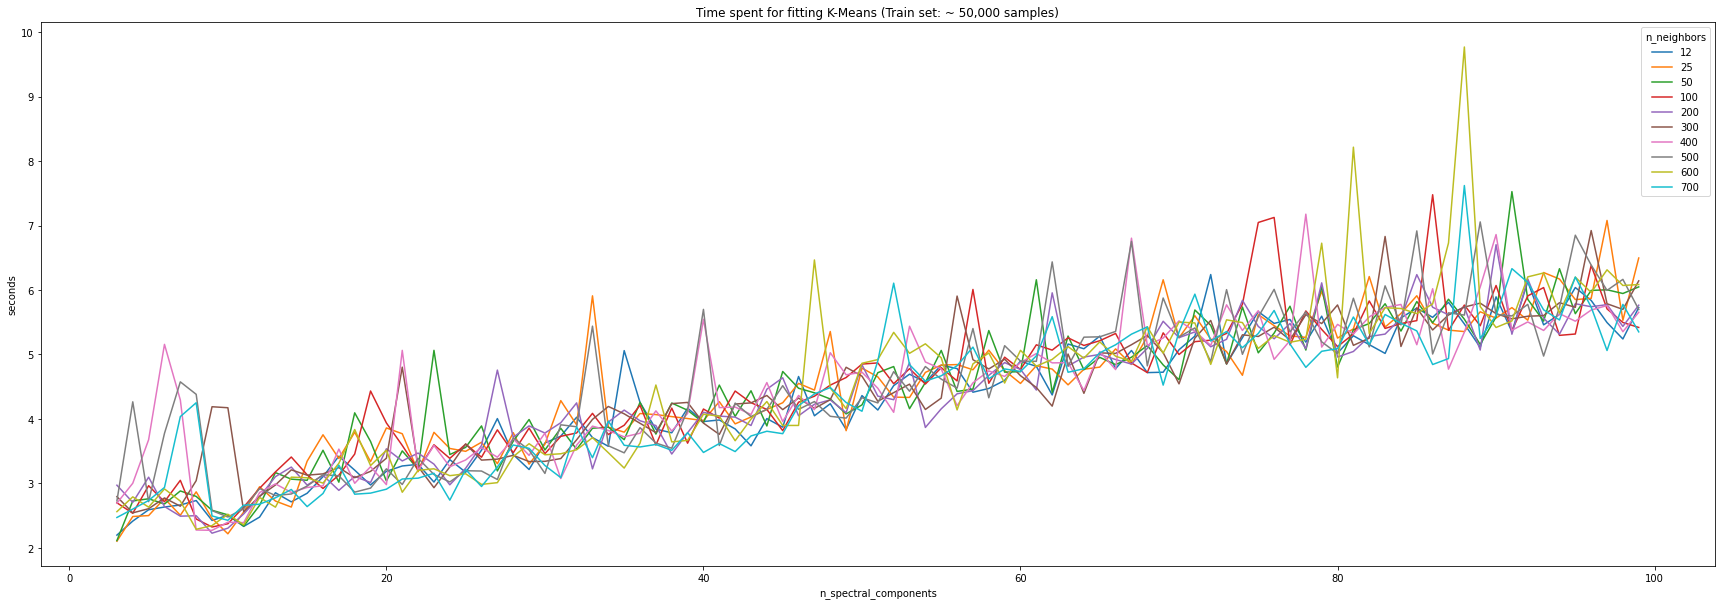

In [20]:
dt_kmeans_arr = np.array(dt_kmeans_list).reshape(len(n_neighbors_list), 
                                                 spectral_components_list.shape[0])
plt.figure(figsize=(30, 10))
for i, n_neighbors in enumerate(n_neighbors_list):
  plt.plot(spectral_components_list, dt_kmeans_arr[i, :], label=n_neighbors)
plt.xlabel("n_spectral_components")
plt.ylabel("seconds")
plt.title("Time spent for fitting K-Means (Train set: ~ 50,000 samples)")
plt.legend(title="n_neighbors")
plt.show()

In [18]:
row_max = np.where(p_mean_arr == p_mean_arr.max())[0][0]
col_max = np.where(p_mean_arr == p_mean_arr.max())[1][0]

print(f"Row: {row_max}, Column: {col_max}")

Row: 6, Column: 93


In [19]:
print(f"Best Accuracy = {p_mean_arr[row_max, col_max]}% --> n_neighbors = {n_neighbors_list[row_max]}, n_spectral_components = {spectral_components_list[col_max]}")

Best Accuracy = 74.10000000000001% --> n_neighbors = 400, n_spectral_components = 96


In [22]:
p_mean_arr.shape

(10, 97)

In [23]:
n_neighbors = n_neighbors_list[row_max]
n_components = spectral_components_list[col_max]
KN = kneighbors_graph(X_tsne, n_neighbors=n_neighbors, mode='connectivity', include_self=True)
V = spectral_embedding(KN, n_components=n_components, norm_laplacian=False, drop_first=False)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [24]:
Z = (255 * (V - V.min()) / np.ptp(V)).astype(int)  
for n in range(spectral_components_list[col_max]):
  plt.figure(figsize=(30, 10))
  cmap = plt.cm.hot
  plt.scatter(X_tsne[:, 0], X_tsne[:, 1], color=cmap(Z[:, n]))
  plt.xlabel("x1"), plt.ylabel("x2")
  plt.title(f"eigenvalue {n}")
  sm = plt.cm.ScalarMappable(cmap=cmap)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Spectral clustering

In [12]:
n_neighbors = 400 #n_neighbors_list[row_max]
n_components = 100
KN = kneighbors_graph(X_tsne, n_neighbors=n_neighbors, mode='connectivity', include_self=True)
V = spectral_embedding(KN, n_components=n_components, norm_laplacian=False, drop_first=False)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


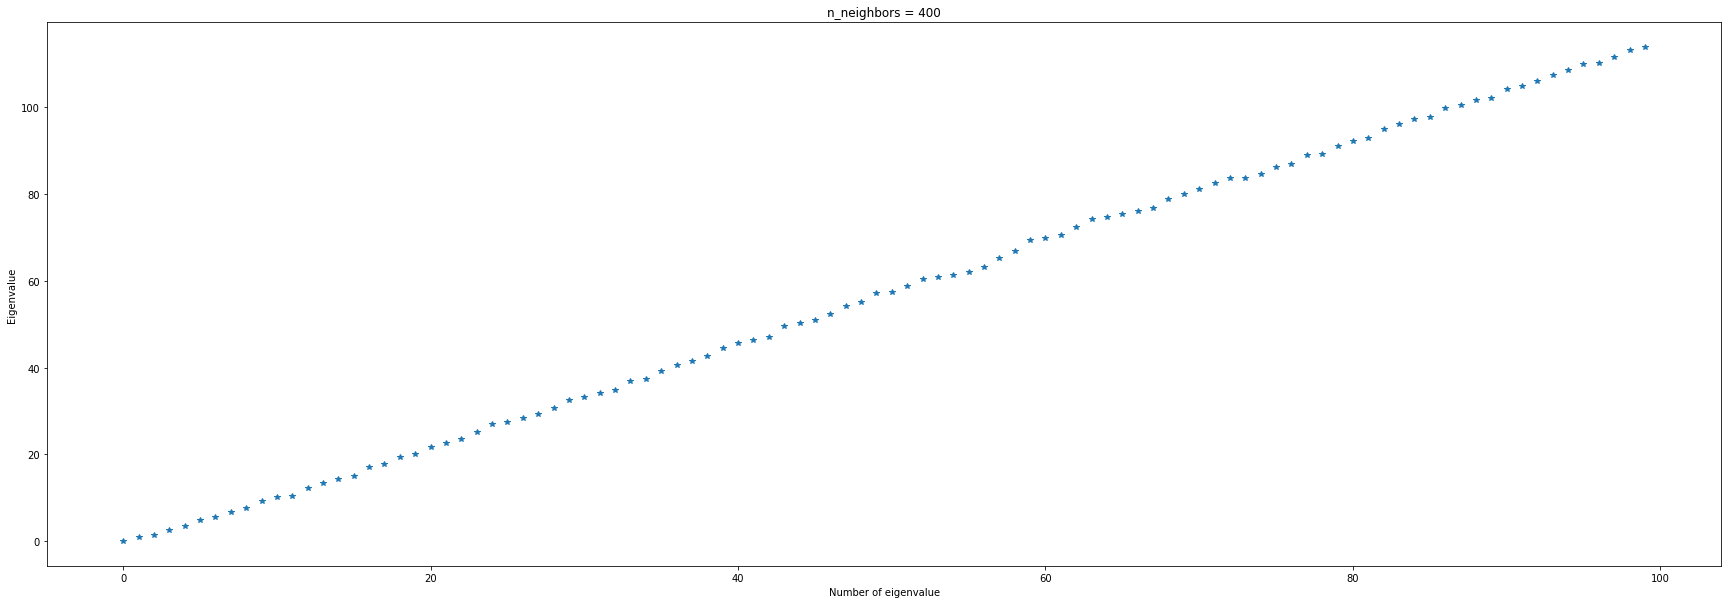

In [13]:
sim_matrix_train = (KN + KN.T)/2
D_train = sparse.diags(np.array(sparse.csr_matrix.sum(sim_matrix_train, axis=1)).flatten(), offsets=0)
L_train = D_train - sim_matrix_train

eigvals_train = list()
for n in range(n_components):
  v = V[:, n]
  lambda_v = sparse.csr_matrix.dot(L_train, v)
  eigval_train = np.divide(lambda_v, v).mean()
  eigvals_train.append(eigval_train)

plt.figure(figsize=(30, 10))
plt.plot(eigvals_train, "*")
plt.title(f"n_neighbors = {n_neighbors}")
plt.xlabel("Number of eigenvalue")
plt.ylabel("Eigenvalue")
plt.show()

## K-Means

In [ ]:
n_clusters = 10
k_means = KMeans(n_clusters=n_clusters, random_state=0, max_iter=1000)
k_means.fit(V_train[:, 1:])
y_preds = k_means.predict(V_test[:, 1:])

In [ ]:
y_preds

array([9, 6, 4, ..., 0, 5, 3], dtype=int32)

In [ ]:
p_list = list()
for true_class in range(10):
  y_preds_c = k_means.predict(V_test[:, 1:][y_test == true_class])
  s = pd.Series(y_preds_c).value_counts()
  p = float("{:.2f}".format(100 * s.max() / s.sum()))
  p_list.append(p)
  print(f"True Class: {true_class} --> {p}%")
p_mean = np.array(p_list).mean()
print("==============================")
print(f"Mean percentage = {p_mean}%")
print("==============================")

True Class: 0 --> 97.96%
True Class: 1 --> 70.48%
True Class: 2 --> 88.47%
True Class: 3 --> 61.68%
True Class: 4 --> 55.4%
True Class: 5 --> 94.96%
True Class: 6 --> 80.17%
True Class: 7 --> 94.16%
True Class: 8 --> 53.39%
True Class: 9 --> 71.26%
Mean percentage = 76.79299999999999%


## Try different number of clusters

In [14]:
n_neighbors = 400   # n_neighbors_list[row_max]
n_components = 96  # spectral_components_list[col_max]
n_clusters_list = [2, 3, 4, 5, 10, 15, 20, 25, 30]

sc_plus_kmeans = MySpectralPlusKMeans()
V, dt_spectral = sc_plus_kmeans.fit_transform(X_tsne, 
                                              n_neighbors=n_neighbors, 
                                              spectral_components=n_components)

V_train = V[:X_train.shape[0], :n_components]
V_test = V[X_train.shape[0]:, :n_components]

for n_clusters in n_clusters_list:
  dt_kmeans = sc_plus_kmeans.fit_kmeans(V_train, n_clusters=n_clusters)
  y_preds = sc_plus_kmeans.predict(V_test)
  plt.figure(figsize=(30, 10))
  plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=y_preds)
  plt.xlabel("x1")
  plt.ylabel("x2")
  plt.title(f"n_neighbors = {n_neighbors}, spectral_components = {n_components} (n_clusters = {n_clusters})")
  plt.show()

Output hidden; open in https://colab.research.google.com to view.